## learning-AI101 : IMDB prediction (RNN)
- 혼자 공부하는 머신러닝과 딥러닝 : 486p~525p
- 2024.08.09.
----

### RNN
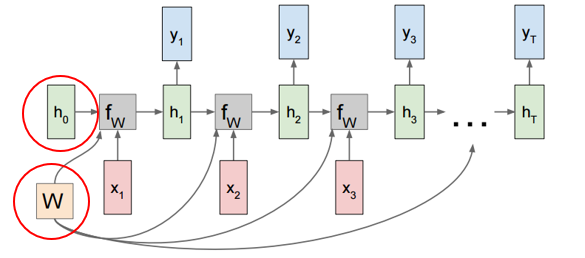
- https://blog.naver.com/PostView.nhn?blogId=winddori2002&logNo=221974391796
- 시계열 데이터 (time-series data / sequential data)를 다룰 때 적합함, 순서를 중시한 학습
    - 위 그림과 같이, 특정 입력에 대한 출력이 다시 recurrent하게 순환하여 재입력받음 -> 이를 통하여 이전 데이터의 학습 결과가 재활용될 수 있다는 것
    - 당연히, sequence의 가장 최근의 component가 hidden state (출력)에 가장 큰 영향을 미칠 것
    - 반대로 상대적으로 오래된 component에 대한 정보는 시간이 지날수록 잊혀짐 (미분하였을 때 기울기가 0으로 수렴 / vanishing gradient) -> 이에 대한 해결책으로 LSTM의 등장
- RNN vs feed-forward
    - feed-forward : 이전 학습에 사용된 데이터를 기억하고 있지 않음.
        - ex) i am a human에서 human을 학습 시 i am a에 대한 정보를 기억하고 있지 않음
    - RNN : 이전 학습의 결과가 다시 입력으로 순환되어 들어가기 때문에 이전 정보를 담고 있음.
- 위 사진의 절차
    - (1) 전 시점의 hidden state와 현 시점의 x를 이용하여 현 시점의 hidden state 구함
    - (2) 현 시점의 hidden state로 현 시점의 y 출력값을 구함
    - (3) 다시 넘겨주어 반복
    - h0 (초기 hidden state)는 0, 기본적으로 activation 비선형 함수는 tanh 사용 (-1~1의 sigmoid)
    - 각 가중치는 서로 공유되어 있음 (sequence 전체에 parameter를 공유한다는 것)
- 특징
    - 일반적으로 샘플마다 2개의 차원을 지님 (sequence 길이, 단어 표현)
    - 순환층의 마지막 출력은 1차원이라 Flatten() 층이 필요하지 않음
    - CNN와 동일히 끝쪽에는 Dense layer를 배치하여 classification or regression

In [48]:
# imdb 데이터 준비

from tensorflow.keras.datasets import imdb

(train_input, train_target), (X_test, y_test) = imdb.load_data(num_words=300) # 자주 사용하는 단어 300개 (어휘 사전)
    
print(train_input.shape, X_test.shape)

(25000,) (25000,)


In [49]:
print(len(train_input[0])) # 218개의 token, token == 단어
print (train_input[0])
print (train_target[0:11]) # 부정 : 0 / 긍정 : 1

218
[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 2, 284, 5, 150, 4, 172, 112, 167, 2, 2, 2, 39, 4, 172, 2, 2, 17, 2, 38, 13, 2, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 2, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 2, 12, 8, 2, 8, 106, 5, 4, 2, 2, 16, 2, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 2, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 7, 4, 2, 2, 13, 104, 88, 4, 2, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 2, 26, 2, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]
[1 0 0 1 0 0 1 0 1 0 1]


imdb는 이미 각 단어를 정수로 표현이 완료되어 있는 상태라 위와 같이 나타난 것을 확인 가능하다. 정수에는 별 다른 의미가 없으며, 단지 번호를 매긴 것 뿐이다. 이미 예약되어 있는 번호는 아래와 같다.

- 0 : padding (보통은 pre)
- 1 : 문장 첫번째 단어를 의미
- 2 : 어휘 사전에 등장하지 않는 언어들
- 나머지 : 어휘 사전에 등장한 언어들 (근데 각 단어마다 번호가 붙어진 것 뿐)

하지만, RNN에서는 숫자가 높은 component의 중요도를 더 높게 보기 때문에 공평한 학습이 이루어지지 않아, 따로 전처리가 필요하다. 아래와 같은 전처리 방법이 존재한다.
- label encoding
- one-hot encoding
- embedding layer
    - 만약 10을 one-hot encoding한다고 가정한다면, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] 형식일 것이다. 이는 너무나도 고차원이며, 심각한 메모리 손실을 낳는다.
    - 따라서 훈련 데이터로부터 학습하여 최적의 차원을 찾아 0과 1이 아닌 실수값으로 밀집하게 구성한다면, [-1.2, 2.1, 3 ...]과 같이 표현 가능하다.
    
본 실습에선 embedding layer를 사용한다.

In [50]:
# train set, val set 

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_input, train_target, test_size=0.2)

print (X_train.shape, X_val.shape, X_test.shape)

(20000,) (5000,) (25000,)


padding 과정을 통하여 각 데이터의 길이를 맞추어준다.

- 만약 maxlen보다 토큰의 갯수가 많다면 : 앞쪽 sequence의 일부를 자른다.
- 만약 maxlen이랑 토큰의 갯수가 동일하다면 pass
- 이외의 상황이면, 모자란 토큰의 갯수만큼 0을 앞쪽에 배치한다. (설정으로 뒷쪽에 배치 가능)
    - 앞쪽에 배치하는 까닭은, 비교적 뒷쪽의 토큰이 앞쪽의 토큰보다 hidden state에 가장 큰 영향을 미치기 때문이다.

In [51]:
# padding

from keras.preprocessing.sequence import pad_sequences

X_train_seq = pad_sequences(X_train, maxlen=100)
X_val_seq = pad_sequences(X_val, maxlen=100)
X_test_seq = pad_sequences(X_test, maxlen=100)

for i in range (len(X_train_seq)) : 
    if X_train_seq[i][0] == 0 : 
        print (i)
        print (X_train_seq[i])
        break

4
[  0   0   0   0   0   0   0   0   0   0   0   1  13   2  14  31   8  67
   2   2  31  53  58  59  70   2  21 152  79   6   2  11  14   2   4   2
   2   9  35   2   2   2   7   2   2 215  28 216  39   6   2   2  88   4
  20   9   2   2   8   2   4   2   2  97   2   2 168   2 225   6  66   2
   2   2  21  57  85   2 290   2  14  20   9  78  21  24   2  38   4   2
  62  81  73  24   8   2  12  23  68   2]


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 16)           4800      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 5009 (19.57 KB)
Trainable params: 5009 (19.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


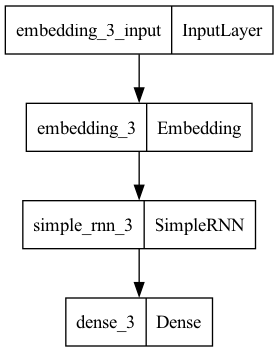

In [52]:
# modelling

from tensorflow import keras

model = keras.Sequential([
    keras.layers.Embedding(300, 16, input_length=100), # 300 : 어휘사전 크기, 16 : 임베딩 벡터 크기
    keras.layers.SimpleRNN(8),
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()
keras.utils.plot_model(model)

In [53]:
# compile

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics='accuracy')

In [54]:
# fit

history = model.fit (X_train_seq, y_train, 
                     validation_data=(X_val_seq, y_val),
                     epochs=25, verbose=True, batch_size=64)

Epoch 1/25
313/313 [==============================] - 5s 13ms/step - loss: 0.6924 - accuracy: 0.5156 - val_loss: 0.6897 - val_accuracy: 0.5292
Epoch 2/25
313/313 [==============================] - 4s 13ms/step - loss: 0.6825 - accuracy: 0.5628 - val_loss: 0.6855 - val_accuracy: 0.5444
Epoch 3/25
313/313 [==============================] - 4s 13ms/step - loss: 0.6688 - accuracy: 0.5879 - val_loss: 0.6686 - val_accuracy: 0.5770
Epoch 4/25
313/313 [==============================] - 4s 13ms/step - loss: 0.6603 - accuracy: 0.5962 - val_loss: 0.6851 - val_accuracy: 0.5448
Epoch 5/25
313/313 [==============================] - 4s 12ms/step - loss: 0.6540 - accuracy: 0.6077 - val_loss: 0.6843 - val_accuracy: 0.5528
Epoch 6/25
313/313 [==============================] - 4s 13ms/step - loss: 0.6454 - accuracy: 0.6281 - val_loss: 0.7136 - val_accuracy: 0.5478
Epoch 7/25
313/313 [==============================] - 4s 13ms/step - loss: 0.6288 - accuracy: 0.6467 - val_loss: 0.6325 - val_accuracy: 0.6560

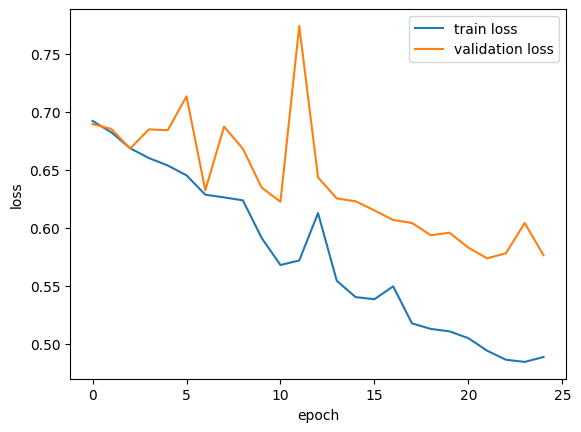

In [55]:
# 훈련 손실과 검증 손실 그래프

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [56]:
# classification report and confusion matrix

from sklearn.metrics import classification_report, confusion_matrix

print (f"train score, test score : ", model.evaluate(X_train_seq, y_train), model.evaluate(X_test_seq, y_test))

y_pred_prob = model.predict(X_test_seq)

if y_pred_prob.shape[1] == 1 :  
    y_pred_classes = (y_pred_prob > 0.5).astype("int32").flatten()
    
else :
    y_pred_classes = np.argmax(y_pred_prob, axis=1)

if y_test.ndim > 1 :
    y_test_classes = np.argmax(y_test, axis=1)
    
else :
    y_test_classes = y_test

print(f"confusion matrix : \n{confusion_matrix(y_test_classes, y_pred_classes)}")
print(f"classification report : {classification_report(y_test_classes, y_pred_classes)}")

782/782 [==============================] - 3s 4ms/step - loss: 0.5736 - accuracy: 0.7231
train score, test score :  [0.4929541051387787, 0.7725499868392944] [0.5735869407653809, 0.7230799794197083]
782/782 [==============================] - 3s 4ms/step
confusion matrix : 
[[9731 2769]
 [4154 8346]]
classification report :               precision    recall  f1-score   support

           0       0.70      0.78      0.74     12500
           1       0.75      0.67      0.71     12500

    accuracy                           0.72     25000
   macro avg       0.73      0.72      0.72     25000
weighted avg       0.73      0.72      0.72     25000

